In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from pygbif import registry
from dotenv import load_dotenv

# Load gbif credentials from .env

In [2]:
load_dotenv()

True

# Read

In [3]:
# path to unzipped CSV downloaded with gbif_download.py
gbif_csv = r"D:\Temp\0079194-251120083545085\0079194-251120083545085.csv"
hierarchical_legend_path = r'HierachicalLegend.xlsx'

# set output paths
gbif_gpkg_out = Path(gbif_csv).with_suffix('.gpkg')
gbif_gpkg_out_simplified = Path(gbif_csv).parent / ('gbif_' + Path(gbif_csv).stem + '_harmonized.gpkg')

# read only subset to get an overview of all attributes
df = pd.read_csv(gbif_csv, sep='\t', low_memory=False, nrows=10)
df.columns

Index(['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class',
       'order', 'family', 'genus', 'species', 'infraspecificEpithet',
       'taxonRank', 'scientificName', 'verbatimScientificName',
       'verbatimScientificNameAuthorship', 'countryCode', 'locality',
       'stateProvince', 'occurrenceStatus', 'individualCount',
       'publishingOrgKey', 'decimalLatitude', 'decimalLongitude',
       'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation',
       'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day',
       'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord',
       'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber',
       'identifiedBy', 'dateIdentified', 'license', 'rightsHolder',
       'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted',
       'mediaType', 'issue'],
      dtype='object')

In [4]:
# Read only relevant most relevant columns
fields = ['decimalLongitude', 'decimalLatitude', 'countryCode', 'species', 'genus', 'scientificName', 'taxonKey',
          'taxonRank', 'year', 'coordinateUncertaintyInMeters', 'license', 'recordedBy', 'gbifID', 'collectionCode',
          'datasetKey', 'issue', 'basisOfRecord', 'individualCount', 'occurrenceStatus']

df = pd.read_csv(gbif_csv, usecols=fields, sep='\t', low_memory=False)

len(df)

21864208

In [5]:
# Overview of fraction of missing values
# Create a list of tuples containing the column name and its null value ratio
ratios = [(col, round(df[col].isnull().sum() / df[col].shape[0], 2)) for col in df.columns]
# Sort the list by the null value ratio
from operator import itemgetter
ratios = sorted(ratios, key=itemgetter(1), reverse=True)
# Print the sorted list
print("\n".join(f"{col} {ratio}" for col, ratio in ratios))

individualCount 0.88
collectionCode 0.55
recordedBy 0.3
coordinateUncertaintyInMeters 0.23
issue 0.15
species 0.01
gbifID 0.0
datasetKey 0.0
genus 0.0
taxonRank 0.0
scientificName 0.0
countryCode 0.0
occurrenceStatus 0.0
decimalLatitude 0.0
decimalLongitude 0.0
year 0.0
taxonKey 0.0
basisOfRecord 0.0
license 0.0


# Filter

## Drop observations with high or unnown coordinate uncertainty

array([[<Axes: title={'center': 'coordinateUncertaintyInMeters'}>]],
      dtype=object)

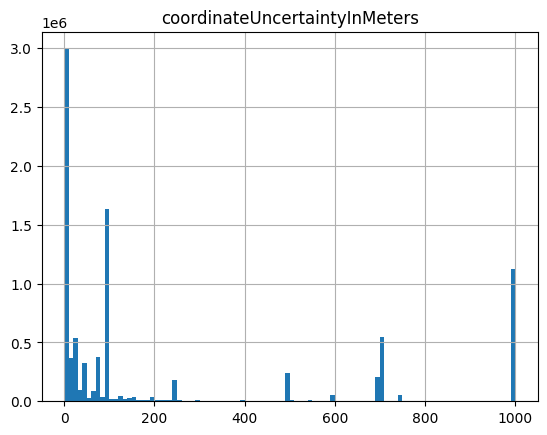

In [6]:
df.dropna(subset=['coordinateUncertaintyInMeters'], inplace=True)
df = df[df['coordinateUncertaintyInMeters'].le(1000)]
df.hist(column='coordinateUncertaintyInMeters', bins=100)

In [7]:
df = df[df['coordinateUncertaintyInMeters'].le(10)]
len(df)

2990819

## Drop rather old observations

array([[<Axes: title={'center': 'year'}>]], dtype=object)

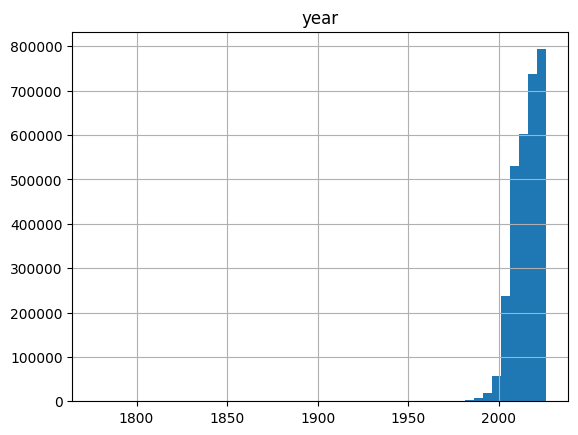

In [8]:
df.hist(column='year', bins=50)

In [9]:
df = df[df['year'].ge(2010)]
len(df)

2319533

In [10]:
tokens = df['issue'].str.split(';', expand=True).stack()
counts = tokens.value_counts()
print(counts)

CONTINENT_DERIVED_FROM_COORDINATES                   1788503
COORDINATE_ROUNDED                                   1173387
TAXON_ID_NOT_FOUND                                   1173184
FOOTPRINT_WKT_MISMATCH                                365139
COUNTRY_DERIVED_FROM_COORDINATES                      311936
GEODETIC_DATUM_ASSUMED_WGS84                          274837
TAXON_CONCEPT_ID_NOT_FOUND                            146701
OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COUNT       44388
INDIVIDUAL_COUNT_INVALID                               18999
MODIFIED_DATE_INVALID                                   7183
IDENTIFIED_DATE_INVALID                                 2631
INSTITUTION_MATCH_FUZZY                                 1857
RECORDED_DATE_MISMATCH                                  1474
ELEVATION_MIN_MAX_SWAPPED                               1473
OCCURRENCE_STATUS_UNPARSABLE                             879
COLLECTION_MATCH_FUZZY                                   750
INSTITUTION_COLLECTION_M

## Drop records with nan in the issue field and long tail of rather rare issues

In [11]:
df.dropna(subset=['issue'], inplace=True)
len(df) 

1868484

In [12]:
drop_issues = ['IDENTIFIED_DATE_UNLIKELY', 'AMBIGUOUS_INSTITUTION', 'INDIVIDUAL_COUNT_CONFLICTS_WITH_OCCURRENCE_STATUS', 'COUNTRY_INVALID', 'DEPTH_UNLIKELY', 'CONTINENT_INVALID',
               'MODIFIED_DATE_UNLIKELY', 'CONTINENT_COUNTRY_MISMATCH', 'FOOTPRINT_SRS_INVALID', 'TAXON_MATCH_SCIENTIFIC_NAME_ID_IGNORED', 'COORDINATE_REPROJECTED', 'FOOTPRINT_WKT_INVALID',
               'BASIS_OF_RECORD_INVALID', 'COUNTRY_MISMATCH', 'CONTINENT_COORDINATE_MISMATCH', 'RECORDED_DATE_MISMATCH', 'GEODETIC_DATUM_INVALID', 'OCCURRENCE_STATUS_UNPARSABLE']
df = df[~df['issue'].str.contains('|'.join(drop_issues))]
len(df)

1864987

In [13]:
# records do at least have genus level information
df['taxonRank'].unique()

array(['SPECIES', 'SUBSPECIES', 'VARIETY', 'FORM', 'GENUS'], dtype=object)

## Drop records that refer to absence of the species

<Axes: title={'center': 'Counts of records for presence / absence'}, xlabel='occurrenceStatus'>

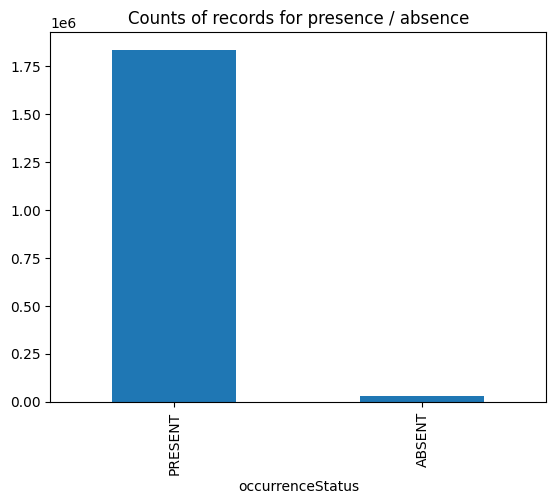

In [14]:
df['occurrenceStatus'].value_counts().plot(kind='bar', title='Counts of records for presence / absence')

In [15]:
df = df[df['occurrenceStatus'].eq('PRESENT')]
len(df)

1835589

## Get dataset title from metatadata for remaining records

In [16]:
dskey_list = df['datasetKey'].unique()
print(len(dskey_list))
dstitle_list = []
for dskey in dskey_list:
    print(f'Querying dataset with key {dskey}')
    metadata = registry.datasets(uuid=dskey)
    dstitle_list.append(metadata['title'])

464
Querying dataset with key c7730a08-74b4-48cd-80a7-831a19ac660d
Querying dataset with key c877cc39-da89-483b-a5b8-a438229222fa
Querying dataset with key c6050fc7-ce45-449f-b4a4-daa92cc0f03a
Querying dataset with key d0aa984e-c6d3-45ee-8fc0-df1df8f4126b
Querying dataset with key d29d79fd-2dc4-4ef5-89b8-cdf66994de0d
Querying dataset with key 066c8a43-ce9f-4cf3-a428-44fb698f079b
Querying dataset with key 07a5ec6c-e271-4d6a-865c-7f9a6b484514
Querying dataset with key 0a013f89-5381-4578-9d82-5f28fd5f1ef6
Querying dataset with key df12ca07-f133-4550-ab3b-fde13f0e76ba
Querying dataset with key 14d5676a-2c54-4f94-9023-1e8dcd822aa0
Querying dataset with key e45c7d91-81c6-4455-86e3-2965a5739b1f
Querying dataset with key e5f16d86-e225-4822-97be-a64ce17079c7
Querying dataset with key e765780e-42d8-473f-a210-6365554f07b4
Querying dataset with key 1c736f5f-18d4-40d3-b25a-ec9d3c3500c7
Querying dataset with key 23f9546d-6ad8-41d4-9c9b-3ecf864c15d0
Querying dataset with key 25d4f82b-b2bc-4197-bc11-2

ConnectTimeout: HTTPSConnectionPool(host='api.gbif.org', port=443): Max retries exceeded with url: /v1/dataset/838475f4-f762-11e1-a439-00145eb45e9a?limit=100 (Caused by ConnectTimeoutError(<HTTPSConnection(host='api.gbif.org', port=443) at 0x1a3bfda1d10>, 'Connection to api.gbif.org timed out. (connect timeout=None)'))

In [ ]:
map_title_dict = dict(zip(dskey_list, dstitle_list))
pd.options.mode.copy_on_write = True
df['datasetTitle'] = df['datasetKey'].map(map_title_dict)  

## Remove records which are preserved specimens

In [ ]:
df = df[~df['basisOfRecord'].eq('PRESERVED_SPECIMEN')]
len(df)

## Remove some datasets

In [ ]:
# French Forest inventory > acutally 1km grid > https://www.gbif.org/dataset/e5f16d86-e225-4822-97be-a64ce17079c7#description
df = df[~df['datasetKey'].eq('e5f16d86-e225-4822-97be-a64ce17079c7')]
len(df)

## Remove duplicate records at the same point

In [ ]:
# remove duplicates that indicate the same genus at the same location, keep only one
out_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.decimalLongitude, df.decimalLatitude), crs="EPSG:4326")
out_gdf = out_gdf.to_crs(epsg=3035)
out_gdf["x"] = round(out_gdf.geometry.x)
out_gdf["y"] = round(out_gdf.geometry.y)
out_gdf.drop_duplicates(["x", "y", "genus"], inplace=True, keep='first')
len(out_gdf)


In [ ]:
# remove remaining duplicates at the same location, i.e. if not removed in previous step there must be different genuses at the same location, remove all
out_gdf.drop_duplicates(["x", "y"], inplace=True, keep=False)
len(out_gdf)

# Write to GPKG

In [ ]:
out_gdf.to_file(filename=gbif_gpkg_out)

# Harmonise to potential target legend

## Load hierarchical legend for leaf type look up

In [ ]:
hlegend = pd.read_excel(hierarchical_legend_path, sheet_name='Hierarchical Legend')
hlegend = hlegend.iloc[:, 0:4]
hlegend.dropna(subset=['for GBIF query'], inplace=True)
hlegend['Level 1'] = hlegend['Level 1'].ffill()
hlegend['Level 2'] = hlegend['Level 2'].ffill()

In [ ]:
hlegend.head(20)

## Map species and genus to leaf type

In [ ]:
map_species_to_leaftype = dict(zip(hlegend['for GBIF query'], hlegend['Level 1']))

map_genus_to_leaftype = {
    'Eucalyptus': 'Broadleaved evergreen',
    'Laurus': 'Broadleaved evergreen',
    'Pseudotsuga': 'Coniferous',
    'Salix': 'Broadleaved decidious'
}
out_gdf['leaftype_phenology'] = out_gdf['species'].map(map_species_to_leaftype)
out_gdf.loc[out_gdf['leaftype_phenology'].isna(), 'leaftype_phenology'] = out_gdf[out_gdf['leaftype_phenology'].isna()].genus.map(map_genus_to_leaftype)

In [ ]:
out_gdf['leaftype_phenology']

In [ ]:
# check if all entries have a leaftpye assigned
out_gdf[out_gdf['leaftype_phenology'].isna()]

In [ ]:
replace_unmapped_species = {
    'Quercus conferta': 'Quercus frainetto',
    'Torminalis glaberrima': 'Sorbus torminalis',
    'Alnus alnobetula': 'Alnus viridis',
    'Cormus domestica': 'Sorbus domestica',
    'Abies borisii-regis': 'Abies alba'
}
out_gdf['species'] = out_gdf['species'].replace(replace_unmapped_species)
out_gdf['leaftype_phenology'] = out_gdf['species'].map(map_species_to_leaftype)
out_gdf.loc[out_gdf['leaftype_phenology'].isna(), 'leaftype_phenology'] = out_gdf[out_gdf['leaftype_phenology'].isna()].genus.map(map_genus_to_leaftype)
# check if all entries have a leaftpye assigned
out_gdf[out_gdf['leaftype_phenology'].isna()]

In [ ]:
# correct genus names
replace_genus = {
    'Torminalis': 'Sorbus',
    'Cormus': 'Sorbus'
}
out_gdf['genus'] = out_gdf['genus'].replace(replace_genus)

In [ ]:
# get leaftype from leaftype phenology
out_gdf['leaftype'] = out_gdf['leaftype_phenology'].apply(lambda x: x.split(' ')[0])
out_gdf['leaftype'] 

## Map species and genus to level 2 legend

In [ ]:
# map to level 2 labels
map_species_to_level2 = dict(zip(hlegend['for GBIF query'], hlegend['Level 2']))
map_genus_to_level2 = {
    'Eucalyptus': 'Eucalyptus',
    'Laurus': 'Other Broadleaved evergreen',
    'Pseudotsuga': 'Other Coniferous',
    'Salix': 'Other Broadleavd decidious'
}


In [ ]:
out_gdf['label_l2'] = out_gdf['species'].map(map_species_to_level2)
out_gdf.loc[out_gdf['label_l2'].isna(), 'label_l2'] = out_gdf[out_gdf['label_l2'].isna()].genus.map(map_genus_to_level2)
# check if all entries have a le label assigned
out_gdf[out_gdf['label_l2'].isna()]

In [ ]:
out_gdf['label_l2'].value_counts().plot(kind='bar', title='GBIF sample distribution at preliminary classisification level', figsize=(10, 5))
print(len(out_gdf))

## Write GPKG

In [ ]:
out_gdf = out_gdf.assign(comment='', source='GBIF')
out_gdf.to_file(filename=gbif_gpkg_out_simplified)